<a href="https://colab.research.google.com/github/TaranDoebe/CIFAR-10/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

# Allows charts for plt in colab
%matplotlib inline


In [2]:
# Convert MNIST Image Files into Tensor of 4-Dimensions ( # of Images, Height, Width, Color-Channels)

CIFAR_transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.CIFAR10(root='/cnn_data_cifar10', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:10<00:00, 15905192.53it/s]


Extracting /cnn_data_cifar10/cifar-10-python.tar.gz to /cnn_data_cifar10


In [4]:
# Test Data
test_data = datasets.CIFAR10(root='/cnn_data_cifar10', train=False, download=True, transform=CIFAR_transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /cnn_data_cifar10
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /cnn_data_cifar10
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images (10)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 3, 1) # 3 color channels
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(16 * 6 * 6, 120) # results 2 cells ago == 16 filters, 5x5 pixels - 120 = arbitrary neurons
    self.fc2 = nn.Linear(120, 84) # connect output last_arg,
    self.fc3 = nn.Linear(84, 10) # 120 and 84 same principle. But has to end with 10, because of batch size

  def forward(self, X):
    # First Pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2
    #print("Shape after first max_pool:", X.shape)  # Check shape
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2
    #print("Shape after second max_pool:", X.shape)  # Check shape

    # Re-View Data to flatten it out
    X = X.view(-1, 16 * 6 * 6) # -1 so we can vary batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [9]:
# Create instance of Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller lr --> Longer train

In [11]:
import time
start_time = time.time()

# Create Variables to Track (opt: graphs)
epochs = 5
# opt
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # Starts batches at 1
    y_pred = model(X_train) # Get predicted values from training set. Not flattened: 2D
    loss = criterion(y_pred, y_train) # compare predicted value with correct value
    predicted = torch.max(y_pred.data, 1)[1] # add number correct predictions indexed of first point
    batch_corr = (predicted == y_train).sum() # How many we got correct from this batch. True = 1, False = 0. Sum.
    train_corr += batch_corr # keep track as we go along in training.

    # Update our params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b%600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test
  with torch.no_grad(): # No gradient so we dont update weights and biases
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      test_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes.')

Epoch: 0, Batch: 600, Loss: 1.5561734437942505
Epoch: 0, Batch: 1200, Loss: 1.0995103120803833
Epoch: 0, Batch: 1800, Loss: 1.531749963760376
Epoch: 0, Batch: 2400, Loss: 1.6347906589508057
Epoch: 0, Batch: 3000, Loss: 1.7715446949005127
Epoch: 0, Batch: 3600, Loss: 1.6488033533096313
Epoch: 0, Batch: 4200, Loss: 1.370375394821167
Epoch: 0, Batch: 4800, Loss: 2.016120433807373
Epoch: 1, Batch: 600, Loss: 1.618137001991272
Epoch: 1, Batch: 1200, Loss: 1.3326793909072876
Epoch: 1, Batch: 1800, Loss: 1.579071283340454
Epoch: 1, Batch: 2400, Loss: 1.1871851682662964
Epoch: 1, Batch: 3000, Loss: 0.9321337938308716
Epoch: 1, Batch: 3600, Loss: 1.528050184249878
Epoch: 1, Batch: 4200, Loss: 0.5962702035903931
Epoch: 1, Batch: 4800, Loss: 1.8260997533798218
Epoch: 2, Batch: 600, Loss: 1.5478724241256714
Epoch: 2, Batch: 1200, Loss: 1.3209210634231567
Epoch: 2, Batch: 1800, Loss: 1.2809679508209229
Epoch: 2, Batch: 2400, Loss: 0.6496113538742065
Epoch: 2, Batch: 3000, Loss: 0.7600411176681519
E

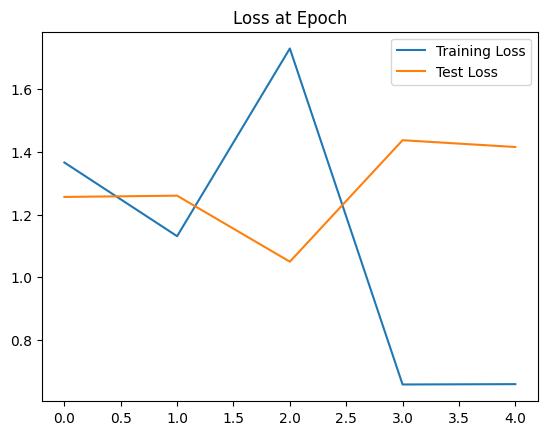

In [12]:
# Graph the loss at each epoch

train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss at Epoch")
plt.legend()

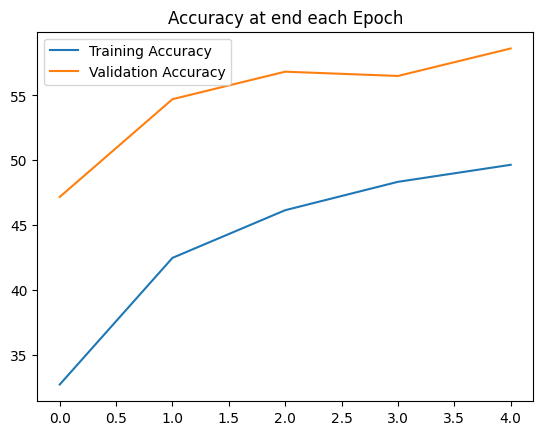

In [13]:
# Graph the accuracy at end each epoch

plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title("Accuracy at end each Epoch")
plt.legend()

In [14]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [15]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [16]:
# Test for correct
percent_correct = correct.item()/len(test_data) * 100
print(f'Percent Correct: {percent_correct}')

Percent Correct: 58.620000000000005


In [17]:
# Correct items
correct.item()

5862

In [18]:
# Application

# Grab an image
test_data[4143] # Tensor with an image in it, at end it shows label

# In this case its a 9

(tensor([[[0.1961, 0.1922, 0.2157,  ..., 0.1333, 0.1333, 0.1294],
          [0.1961, 0.1882, 0.1961,  ..., 0.1373, 0.1412, 0.1373],
          [0.1647, 0.1961, 0.2039,  ..., 0.1373, 0.1373, 0.1333],
          ...,
          [0.6118, 0.6431, 0.6510,  ..., 0.3098, 0.1569, 0.1216],
          [0.5804, 0.5922, 0.5804,  ..., 0.1725, 0.1098, 0.1059],
          [0.4039, 0.4039, 0.4196,  ..., 0.1020, 0.1098, 0.1176]],
 
         [[0.1765, 0.1686, 0.1804,  ..., 0.1137, 0.1137, 0.1098],
          [0.1804, 0.1647, 0.1686,  ..., 0.1176, 0.1216, 0.1176],
          [0.1529, 0.1804, 0.1843,  ..., 0.1176, 0.1176, 0.1137],
          ...,
          [0.6235, 0.6627, 0.6706,  ..., 0.2392, 0.1294, 0.1059],
          [0.5961, 0.6078, 0.5961,  ..., 0.1176, 0.0824, 0.0863],
          [0.4196, 0.4196, 0.4353,  ..., 0.0627, 0.0784, 0.0941]],
 
         [[0.1843, 0.1686, 0.1804,  ..., 0.0980, 0.1020, 0.0980],
          [0.1843, 0.1686, 0.1647,  ..., 0.1020, 0.1098, 0.1059],
          [0.1569, 0.1804, 0.1765,  ...,

In [27]:
# easier
test_data[4143][1]

5

In [28]:
# Grab the data
test_data[4143][0]

tensor([[[0.1961, 0.1922, 0.2157,  ..., 0.1333, 0.1333, 0.1294],
         [0.1961, 0.1882, 0.1961,  ..., 0.1373, 0.1412, 0.1373],
         [0.1647, 0.1961, 0.2039,  ..., 0.1373, 0.1373, 0.1333],
         ...,
         [0.6118, 0.6431, 0.6510,  ..., 0.3098, 0.1569, 0.1216],
         [0.5804, 0.5922, 0.5804,  ..., 0.1725, 0.1098, 0.1059],
         [0.4039, 0.4039, 0.4196,  ..., 0.1020, 0.1098, 0.1176]],

        [[0.1765, 0.1686, 0.1804,  ..., 0.1137, 0.1137, 0.1098],
         [0.1804, 0.1647, 0.1686,  ..., 0.1176, 0.1216, 0.1176],
         [0.1529, 0.1804, 0.1843,  ..., 0.1176, 0.1176, 0.1137],
         ...,
         [0.6235, 0.6627, 0.6706,  ..., 0.2392, 0.1294, 0.1059],
         [0.5961, 0.6078, 0.5961,  ..., 0.1176, 0.0824, 0.0863],
         [0.4196, 0.4196, 0.4353,  ..., 0.0627, 0.0784, 0.0941]],

        [[0.1843, 0.1686, 0.1804,  ..., 0.0980, 0.1020, 0.0980],
         [0.1843, 0.1686, 0.1647,  ..., 0.1020, 0.1098, 0.1059],
         [0.1569, 0.1804, 0.1765,  ..., 0.1020, 0.1059, 0.

In [33]:
# Reshape it
test_data[4143][0].reshape(3, 32, 32)




tensor([[[0.1961, 0.1922, 0.2157,  ..., 0.1333, 0.1333, 0.1294],
         [0.1961, 0.1882, 0.1961,  ..., 0.1373, 0.1412, 0.1373],
         [0.1647, 0.1961, 0.2039,  ..., 0.1373, 0.1373, 0.1333],
         ...,
         [0.6118, 0.6431, 0.6510,  ..., 0.3098, 0.1569, 0.1216],
         [0.5804, 0.5922, 0.5804,  ..., 0.1725, 0.1098, 0.1059],
         [0.4039, 0.4039, 0.4196,  ..., 0.1020, 0.1098, 0.1176]],

        [[0.1765, 0.1686, 0.1804,  ..., 0.1137, 0.1137, 0.1098],
         [0.1804, 0.1647, 0.1686,  ..., 0.1176, 0.1216, 0.1176],
         [0.1529, 0.1804, 0.1843,  ..., 0.1176, 0.1176, 0.1137],
         ...,
         [0.6235, 0.6627, 0.6706,  ..., 0.2392, 0.1294, 0.1059],
         [0.5961, 0.6078, 0.5961,  ..., 0.1176, 0.0824, 0.0863],
         [0.4196, 0.4196, 0.4353,  ..., 0.0627, 0.0784, 0.0941]],

        [[0.1843, 0.1686, 0.1804,  ..., 0.0980, 0.1020, 0.0980],
         [0.1843, 0.1686, 0.1647,  ..., 0.1020, 0.1098, 0.1059],
         [0.1569, 0.1804, 0.1765,  ..., 0.1020, 0.1059, 0.

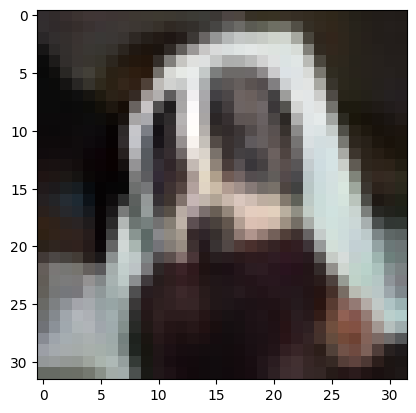

In [58]:
# Extract image and ensure correct shape
image_tensor = test_data[4143][0]

# Reshape and transpose the image tensor to [H, W, C]
image = image_tensor.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.show()

In [59]:
# Pass image through model

model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4145][0].view(1, 3, 32, 32)) # batch size of 1, 3 color channel, 32 x 32 image

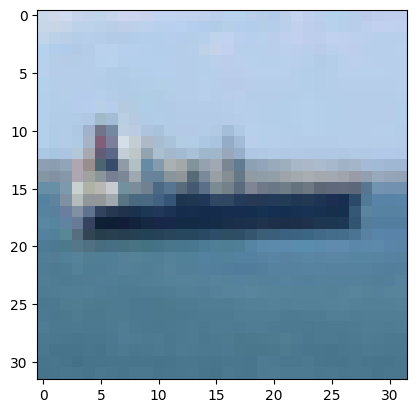

In [60]:
# Extract image and ensure correct shape
image_tensor = test_data[4145][0]

# Reshape and transpose the image tensor to [H, W, C]
image = image_tensor.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.show()

In [61]:
# Check the new prediction, get probabilities of 0,1,2,3,4,5,6,7,8,9
new_prediction

tensor([[ -0.9827,  -9.3729,  -7.8369, -10.4876, -10.6817, -14.7874, -13.3760,
         -15.7399,  -0.4699,  -9.3302]])

In [65]:
new_prediction.argmax()

tensor(8)

In [66]:

# Define the CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get the index of the class with the highest probability
predicted_class_index = new_prediction.argmax().item()

# Get the class name from the index
predicted_class_name = classes[predicted_class_index]

# Print the class name
print(f'The predicted class is: {predicted_class_name}')


The predicted class is: ship
